# Import Libraries

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, silhouette_score, davies_bouldin_score, silhouette_samples

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Data Loading

In [2]:
# 1. Load the LeetCode data
df = pd.read_csv("../../Profile_Data/leetcode_profiles.csv")

print(f"Dataset: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()

Dataset: (2992, 7)

Columns: ['Username', 'Ranking', 'Reputation', 'All_Solved', 'Easy_Solved', 'Medium_Solved', 'Hard_Solved']


,Username,Ranking,Reputation,All_Solved,Easy_Solved,Medium_Solved,Hard_Solved
0,Tima_,559948,0,247,51,109,87
1,sethles,77,533,3498,872,1894,732
2,user6150B,5000001,0,0,0,0,0
3,SyberCage,91351,2,667,139,364,164
4,VitVelloreCoder,2012618,-32,63,14,36,13


# Data Cleaning

In [3]:
def clean_data(df):
    print(f"Original shape: {df.shape}")
    
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"After removing duplicates: {df.shape}")
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    
    # Clean text columns (remove special characters)
    def clean_text(text):
        if pd.isna(text):
            return text
        return re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    
    # Apply to text columns that typically have special characters
    text_columns = ['name', 'location', 'username', 'bio', 'company']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].apply(clean_text)
            print(f"   Cleaned special chars from: {col}")
    
    # Fill missing values
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna('Unknown')
    
    # Remove completely empty columns
    df = df.dropna(axis=1, how='all')
    
    # Remove completely empty rows
    df = df.dropna(axis=0, how='all')
    
    print(f"Final cleaned shape: {df.shape}")
    
    return df


# Clean the data
leetcode = clean_data(df)

Original shape: (2992, 7)
After removing duplicates: (2992, 7)
   Cleaned special chars from: username
Final cleaned shape: (2992, 7)


# Feature Selection

In [4]:
features = ['Ranking','Reputation','Easy_Solved', 'Medium_Solved', 'Hard_Solved']
X = df[features]

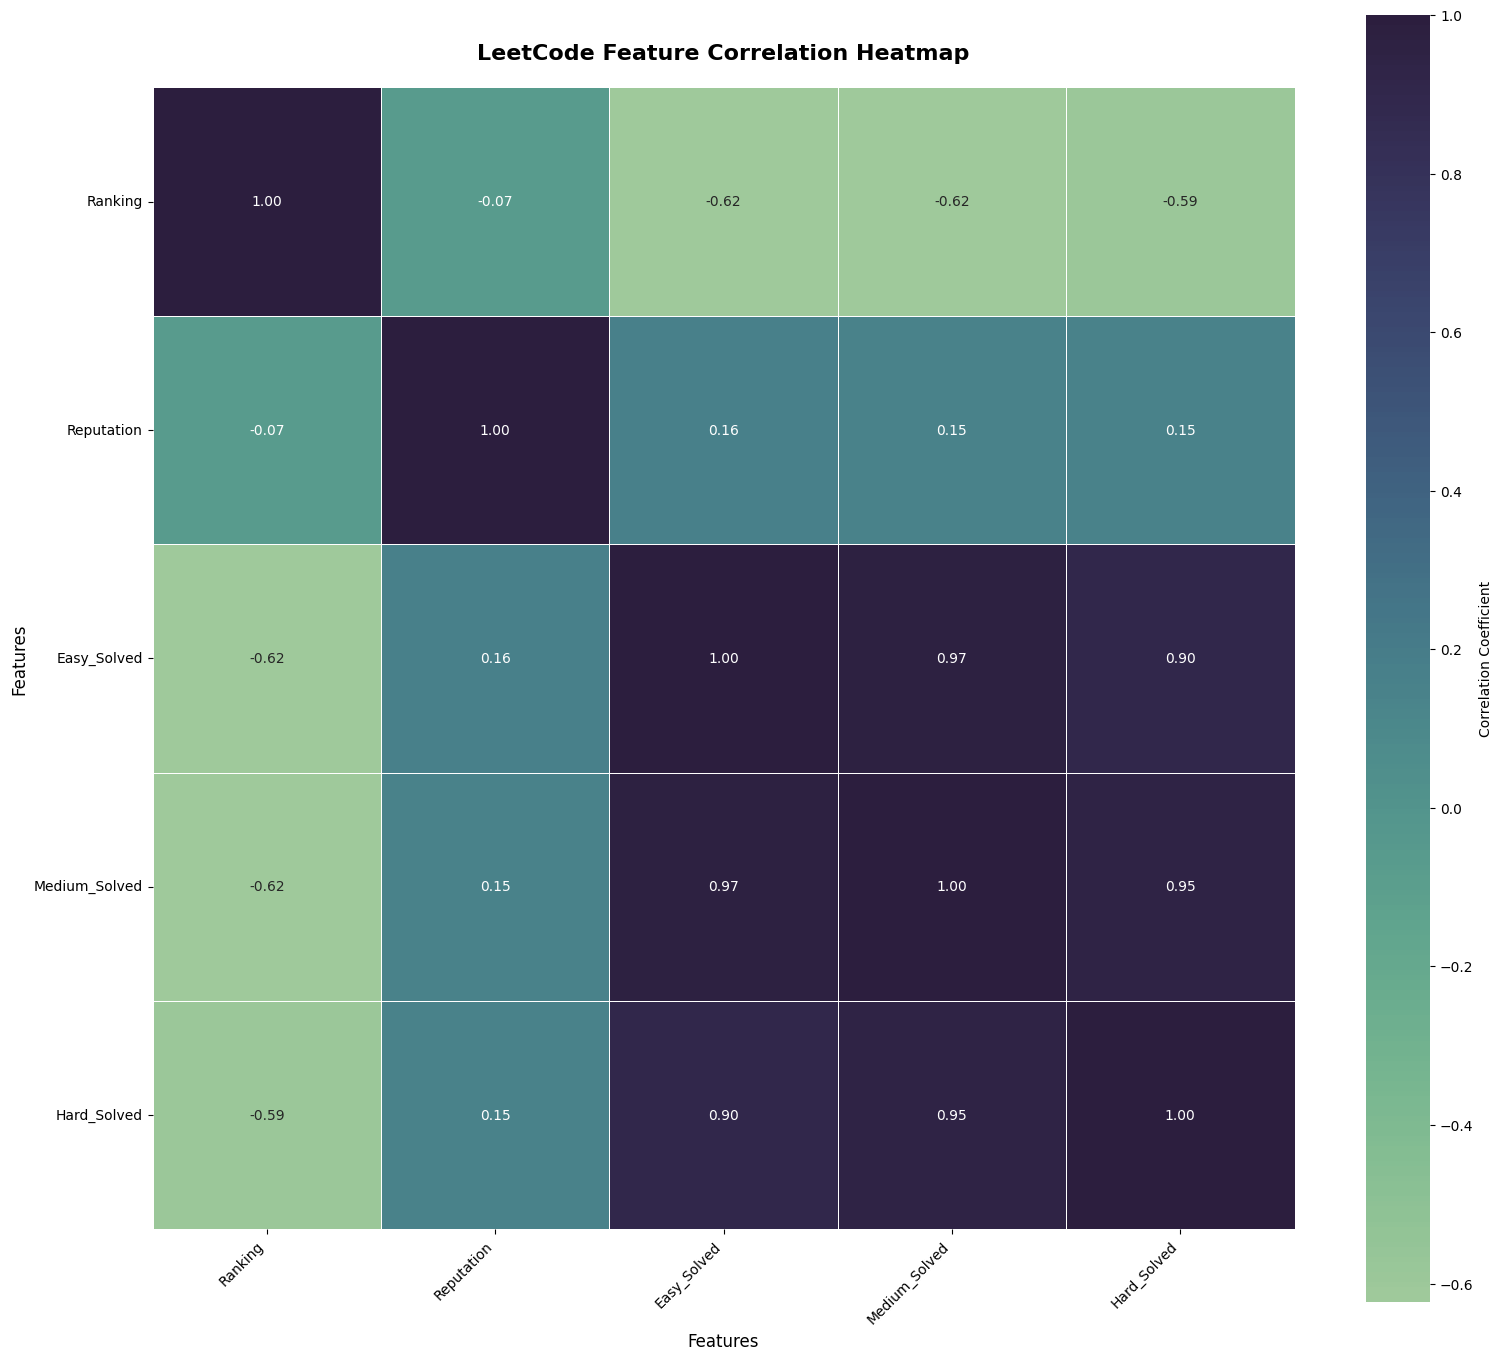

In [5]:
X_with_target = X.copy()

correlation_matrix = X_with_target.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix, 
    annot=True,
    fmt='.2f',
    cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('LeetCode Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Scaling

In [6]:
# Scale the data (Important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means

Testing different numbers of clusters...


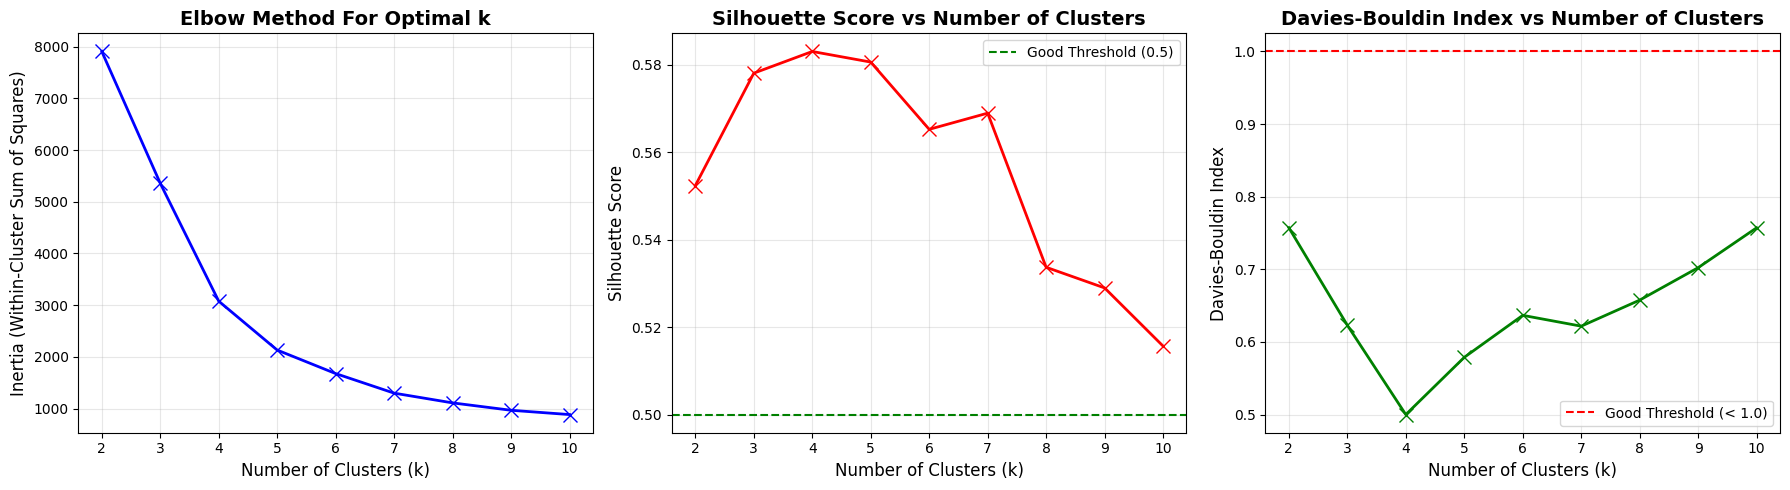


 Optimal number of clusters based on Silhouette Score: 4
   Silhouette Score: 0.583
   Davies-Bouldin Index: 0.500


In [7]:
# Elbow Method to find optimal clusters
print("Testing different numbers of clusters...")
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_temp.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans_temp.labels_))

# Plot Elbow + Silhouette + Davies-Bouldin
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Elbow Plot
ax1.plot(K_range, inertias, 'bx-', linewidth=2, markersize=10)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
ax1.set_title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette Score Plot
ax2.plot(K_range, silhouette_scores, 'rx-', linewidth=2, markersize=10)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax2.axhline(y=0.5, color='green', linestyle='--', label='Good Threshold (0.5)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Davies-Bouldin Index Plot
ax3.plot(K_range, davies_bouldin_scores, 'gx-', linewidth=2, markersize=10)
ax3.set_xlabel('Number of Clusters (k)', fontsize=12)
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax3.set_title('Davies-Bouldin Index vs Number of Clusters', fontsize=14, fontweight='bold')
ax3.axhline(y=1.0, color='red', linestyle='--', label='Good Threshold (< 1.0)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n Optimal number of clusters based on Silhouette Score: {optimal_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.3f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_scores[optimal_k-2]:.3f}")

CLUSTER QUALITY VALIDATION
Number of Clusters: 2
Silhouette Score: 0.552 (Range: -1 to 1, Higher is Better)
Davies-Bouldin Index: 0.757 (Lower is Better)
GOOD: Clusters are well-separated and cohesive


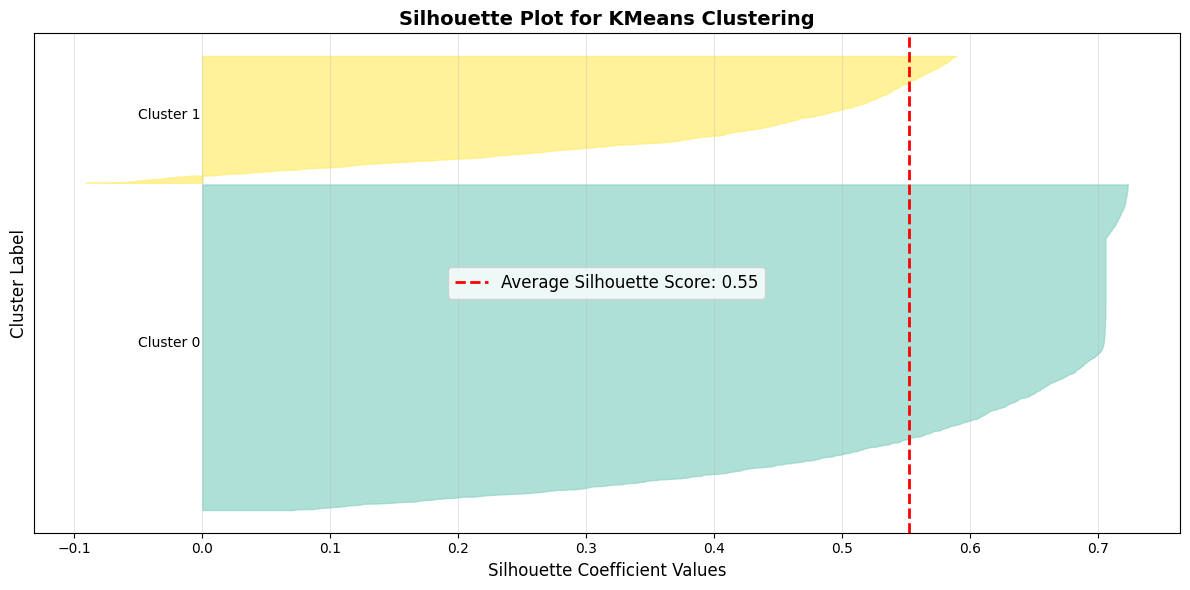


Cluster Distribution:
  Cluster 0: 2153 samples (72.0%)
  Cluster 1: 839 samples (28.0%)
Recruiter_Label
Good    2153
Bad      839
Name: count, dtype: int64


In [8]:
# Applying K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)  # using random_state = 42 so results stay consistent
df['Cluster_Label'] = kmeans.fit_predict(X_scaled)

# Cluster Quality Metrics
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans.labels_)

print("CLUSTER QUALITY VALIDATION")

print(f"Number of Clusters: {kmeans.n_clusters}")
print(f"Silhouette Score: {silhouette_avg:.3f} (Range: -1 to 1, Higher is Better)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (Lower is Better)")

if silhouette_avg > 0.5:
    print("GOOD: Clusters are well-separated and cohesive")
elif silhouette_avg > 0.25:
    print("FAIR: Clusters have some overlap")
else:
    print("POOR: Clusters are not well-defined")

# Silhouette Plot for Visual Validation
fig, ax = plt.subplots(figsize=(12, 6))

silhouette_vals = silhouette_samples(X_scaled, kmeans.labels_)
y_lower = 10

colors = plt.cm.Set3(np.linspace(0, 1, kmeans.n_clusters))

for i in range(kmeans.n_clusters):
    cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label the clusters
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}', fontsize=10)
    
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
           label=f'Average Silhouette Score: {silhouette_avg:.2f}')
ax.set_xlabel("Silhouette Coefficient Values", fontsize=12)
ax.set_ylabel("Cluster Label", fontsize=12)
ax.set_title("Silhouette Plot for KMeans Clustering", fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print cluster distribution
print(f"\nCluster Distribution:")
cluster_counts = pd.Series(kmeans.labels_).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(kmeans.labels_)) * 100
    print(f"  Cluster {cluster_id}: {count} samples ({percentage:.1f}%)")


# Identify which cluster is Good
# K-means doesn't know Good v/s Bad, it knows Group 0 and Group 1
# check which group has the higher average reputation
cluster_0_avg = df[df['Cluster_Label'] == 0]['Ranking'].mean()
cluster_1_avg = df[df['Cluster_Label'] == 1]['Ranking'].mean()

if cluster_1_avg > cluster_0_avg:
    df['Recruiter_Label'] = df['Cluster_Label'].map({1: 'Good', 0: 'Bad'})
else:
    df['Recruiter_Label'] = df['Cluster_Label'].map({0: 'Good', 1: 'Bad'})

print(df['Recruiter_Label'].value_counts())

C:\Users\Anushka\AppData\Local\Temp\ipykernel_23352\2514578758.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Recruiter_Label', data=df, palette={'Good': 'darkgreen', 'Bad': 'darkblue'})


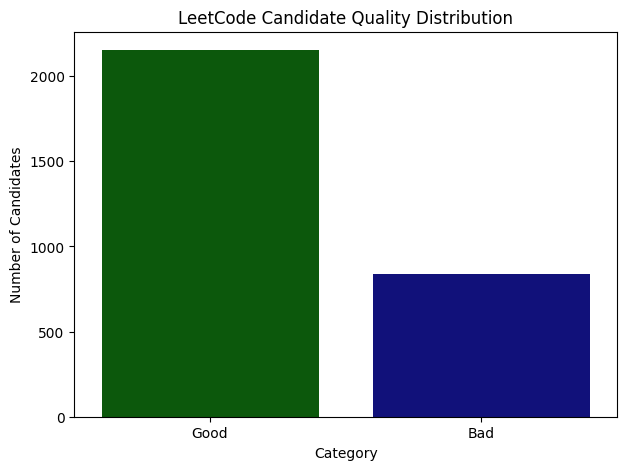

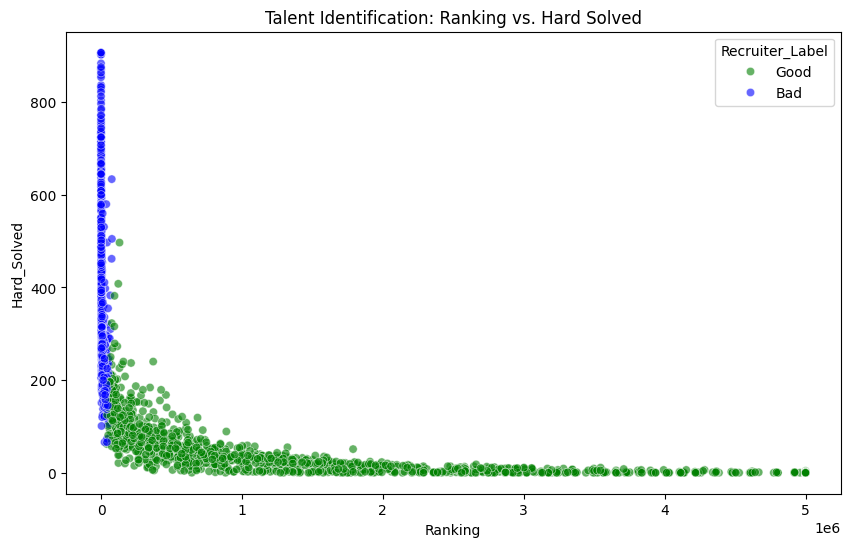

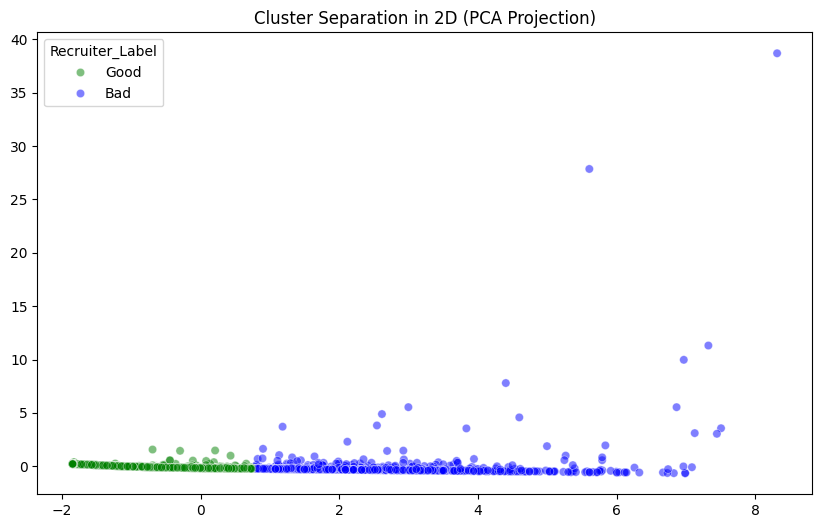

In [9]:
# BAR CHART: Talent Distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Recruiter_Label', data=df, palette={'Good': 'darkgreen', 'Bad': 'darkblue'})
plt.title('LeetCode Candidate Quality Distribution')
plt.ylabel('Number of Candidates')
plt.xlabel('Category')
plt.savefig('../ML_Visualizations/leetcode/leetcode_distribution.png')

# SCATTER PLOT: Reputation vs. Hard Solved
# This shows how the 'Good' group is physically separated in the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Ranking', y='Hard_Solved', hue='Recruiter_Label',
                palette={'Good': 'green', 'Bad': 'blue'}, alpha=0.6)
plt.title('Talent Identification: Ranking vs. Hard Solved')
plt.savefig('../ML_Visualizations/leetcode/leetcode_scatter.png')

# PCA PLOT: High-Dimensional Separation
# This shows how the AI sees the clusters using all 4 features at once
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=df['Recruiter_Label'],
                palette={'Good': 'green', 'Bad': 'blue'}, alpha=0.5)
plt.title('Cluster Separation in 2D (PCA Projection)')
plt.savefig('../ML_Visualizations/leetcode/leetcode_pca.png')

## Train - Test Split

In [10]:
# PREPARE DATA
X = df[features]
y = df['Cluster_Label']

# TRAIN/TEST SPLIT
# We split first so the test set remains pure real world data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

# SMOTE

In [11]:
# APPLY SMOTE (To TRAINING only)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

C:\Users\Anushka\AppData\Local\Temp\ipykernel_23352\1828385421.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Bad (0)', 'Good (1)'], y=before_counts.values, ax=ax[0], palette='Blues')
C:\Users\Anushka\AppData\Local\Temp\ipykernel_23352\1828385421.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Bad (0)', 'Good (1)'], y=after_counts.values, ax=ax[1], palette='crest')


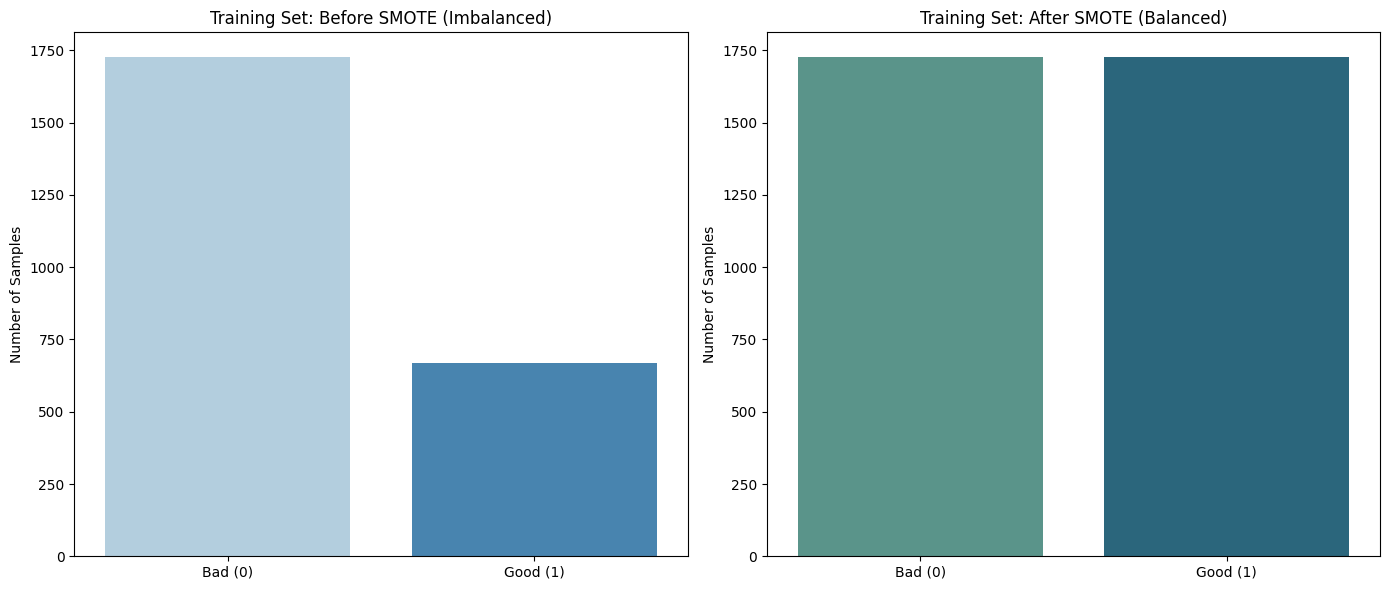

In [12]:
# Visualization plot to show the effect of SMOTE on the training data distribution
before_counts = pd.Series(y_train).value_counts().sort_index()
after_counts = pd.Series(y_train_res).value_counts().sort_index()

# Set up the plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Plot Before SMOTE
sns.barplot(x=['Bad (0)', 'Good (1)'], y=before_counts.values, ax=ax[0], palette='Blues')
ax[0].set_title('Training Set: Before SMOTE (Imbalanced)')
ax[0].set_ylabel('Number of Samples')

# Plot After SMOTE
sns.barplot(x=['Bad (0)', 'Good (1)'], y=after_counts.values, ax=ax[1], palette='crest')
ax[1].set_title('Training Set: After SMOTE (Balanced)')
ax[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

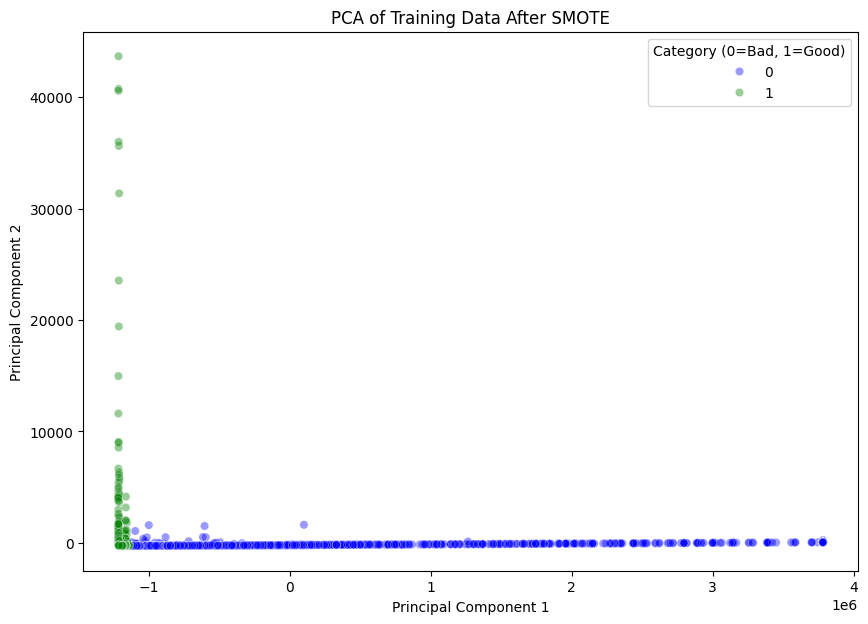

In [13]:
# Using PCA to flatten the resampled data into 2D
pca = PCA(n_components=2)
X_pca_res = pca.fit_transform(X_train_res)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_res[:, 0], y=X_pca_res[:, 1], hue=y_train_res,
                palette={1: 'green', 0: 'blue'}, alpha=0.4)
plt.title('PCA of Training Data After SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Category (0=Bad, 1=Good)')
plt.show()

#

## Random Forest Classifier

Final Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       0.99      1.00      0.99       172

    accuracy                           1.00       599
   macro avg       0.99      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599



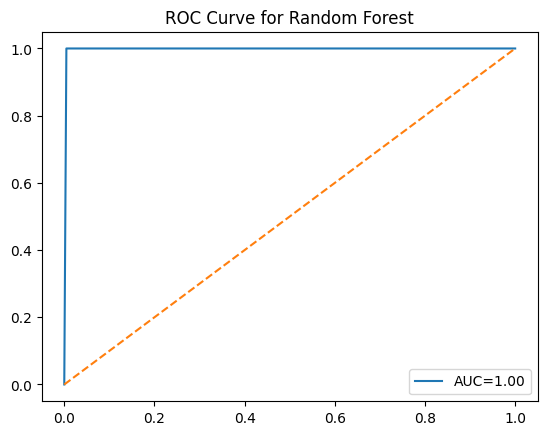


 TOP 10 CANDIDATE PICKS
         Username  Ranking  Reputation  Easy_Solved  Medium_Solved  \
1         sethles       77         533          872           1894   
2975        seryp     8815          16          317            766   
2973   ashish1729      528         644          738           1466   
5       dancooper     2519           1          533            996   
2971       glump1      349          25          698           1511   
902        seeean     7732          22          385            751   
905   vaibhav2740    31448          67          170            639   
908        y2587w      870           4          623           1235   
912   chuchuching    20870           4          251            583   
925       wssx349    16259          31          352            566   

      Hard_Solved  Selection_Probability  
1             732                    1.0  
2975          279                    1.0  
2973          452                    1.0  
5             315               

In [14]:
# Initialize the Random Forest
# n_estimators = 100 means we are using 100 individual decision trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model using SMOTE balanced training data
rf_model.fit(X_train_res, y_train_res)

# Evaluate on Real World unbalanced test set
y_pred = rf_model.predict(X_test)
print("Final Model Performance")
print(classification_report(y_test, y_pred))

# ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title("ROC Curve for Random Forest")
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

# RANKING: Use the model to find the Top 5 Picks
# Get the probability of being Good
df['Selection_Probability'] = rf_model.predict_proba(X)[:, 1]

# Sort by probability, then by Ranking
top_10_candidates_rfm = df.sort_values(by=['Selection_Probability'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates_rfm[['Username', 'Ranking','Reputation','Easy_Solved', 'Medium_Solved', 'Hard_Solved', 'Selection_Probability']])

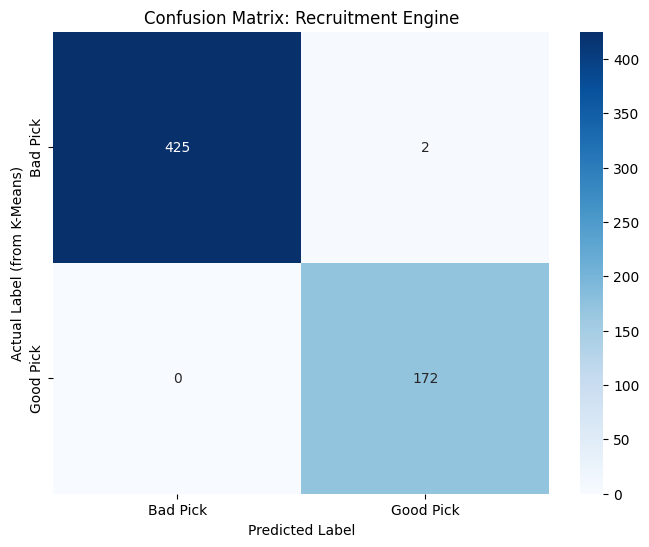

In [15]:
# Generating the matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad Pick', 'Good Pick'],
            yticklabels=['Bad Pick', 'Good Pick'])
plt.title('Confusion Matrix: Recruitment Engine')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label (from K-Means)')
plt.show()

## DecisionTree

Decision Tree Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       0.99      1.00      0.99       172

    accuracy                           1.00       599
   macro avg       0.99      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599



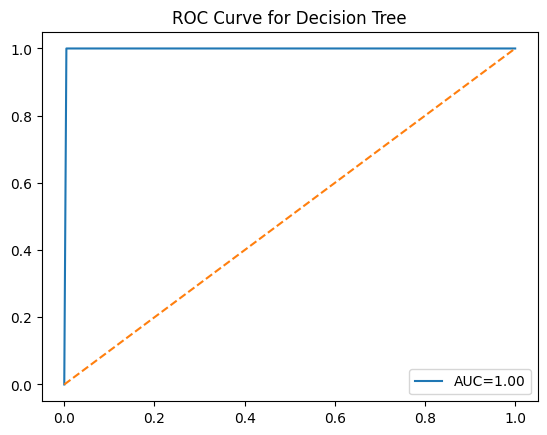


 TOP 10 CANDIDATE PICKS
          Username  Ranking  Reputation  Easy_Solved  Medium_Solved  \
2960   Chelsea_Liu    11630           0          279            623   
430       cybsbbbb     2939           7          443            981   
1193  RedHeadphone    13164         459          391            670   
432      farmerboy     3429          10          459            918   
2964        SUVU01      544          35          724           1435   
433        panyan7    23329           3          265            518   
2966      REWFALTQ    38161           8          185            528   
940        MaskRay    51489         107          175            427   
435        Fishron     7285           1          322            782   
2969         kefaa    24206           0          236            392   

      Hard_Solved  Selection_Probability  
2960          367                   1.00  
430           344                   1.00  
1193          166                   1.00  
432           329    

In [16]:
# Initialize the Decision Tree
# max_depth limits how deep the tree can grow to prevent overfitting
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)

# Training the model using SMOTE balanced training data
dt_model.fit(X_train_res, y_train_res)

# Evaluate on Real World unbalanced test set
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Model Performance")
print(classification_report(y_test, y_pred_dt))

# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.title("ROC Curve for Decision Tree")
plt.plot(fpr_dt, tpr_dt, label=f"AUC={roc_auc_dt:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

# RANKING: Use the model to find the Top 10 Picks
# Get the probability of being Good (1 class)
df['Selection_Probability_dt'] = dt_model.predict_proba(X)[:, 1]

# Sort by probability, then by Ranking
top_10_candidates_dt = df.sort_values(by=['Selection_Probability_dt'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates_dt[['Username', 'Ranking','Reputation','Easy_Solved', 'Medium_Solved', 'Hard_Solved', 'Selection_Probability']])

## XGBoost

XGBoost Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       0.99      1.00      0.99       172

    accuracy                           1.00       599
   macro avg       0.99      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599



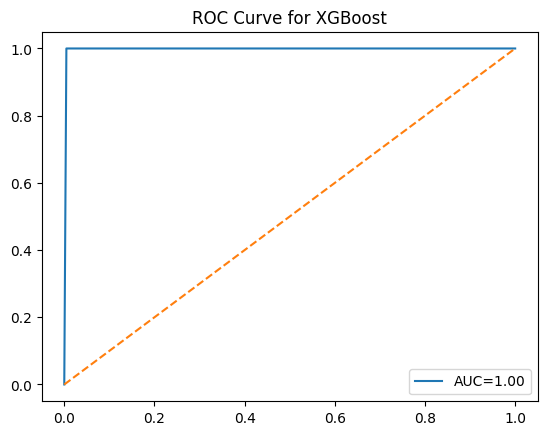


 TOP 10 CANDIDATE PICKS
            Username  Ranking  Reputation  Easy_Solved  Medium_Solved  \
1837    hanifasepthi    29628          73          216            363   
890    anubhav100rao     2992          60          432            935   
1            sethles       77         533          872           1894   
894      masteralphi     3254          41          471            940   
2003           awice      134       11838          792           1668   
2005           rh137     2485         788          464           1020   
2018  vigneshcoder05     1310        1041          593           1140   
2042         hope_ma       56          63          898           1897   
408           serdes     2502         176          431           1017   
2049           hxu10       49        4200          898           1935   

      Hard_Solved  Selection_Probability  
1837          398                    1.0  
890           394                    1.0  
1             732                    1.0  

In [17]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)

# Training the model using SMOTE balanced training data
xgb_model.fit(X_train_res, y_train_res)

# Evaluate on Real World unbalanced test set
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Model Performance")
print(classification_report(y_test, y_pred_xgb))

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.title("ROC Curve for XGBoost")
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC={roc_auc_xgb:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

# RANKING: Use the model to find the Top 10 Picks
# Get the probability of being Good (1 class)
df['Selection_Probability_xgb'] = xgb_model.predict_proba(X)[:, 1]

# Sort by probability, then by Ranking
top_10_candidates_dt = df.sort_values(by=['Selection_Probability_xgb'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates_dt[['Username', 'Ranking','Reputation','Easy_Solved', 'Medium_Solved', 'Hard_Solved', 'Selection_Probability']])

## Model Comparison

MODEL PERFORMANCE COMPARISON

Random Forest:
  Accuracy:  0.997
  Precision: 0.989
  Recall:    1.000
  F1-Score:  0.994

Decision Tree:
  Accuracy:  0.997
  Precision: 0.989
  Recall:    1.000
  F1-Score:  0.994

XGBoost:
  Accuracy:  0.997
  Precision: 0.989
  Recall:    1.000
  F1-Score:  0.994

BEST MODEL: Random Forest (F1-Score: 0.994)

Model Comparison Table:
        Model  Accuracy  Precision  Recall  F1-Score
Random Forest  0.996661   0.988506     1.0   0.99422
Decision Tree  0.996661   0.988506     1.0   0.99422
      XGBoost  0.996661   0.988506     1.0   0.99422


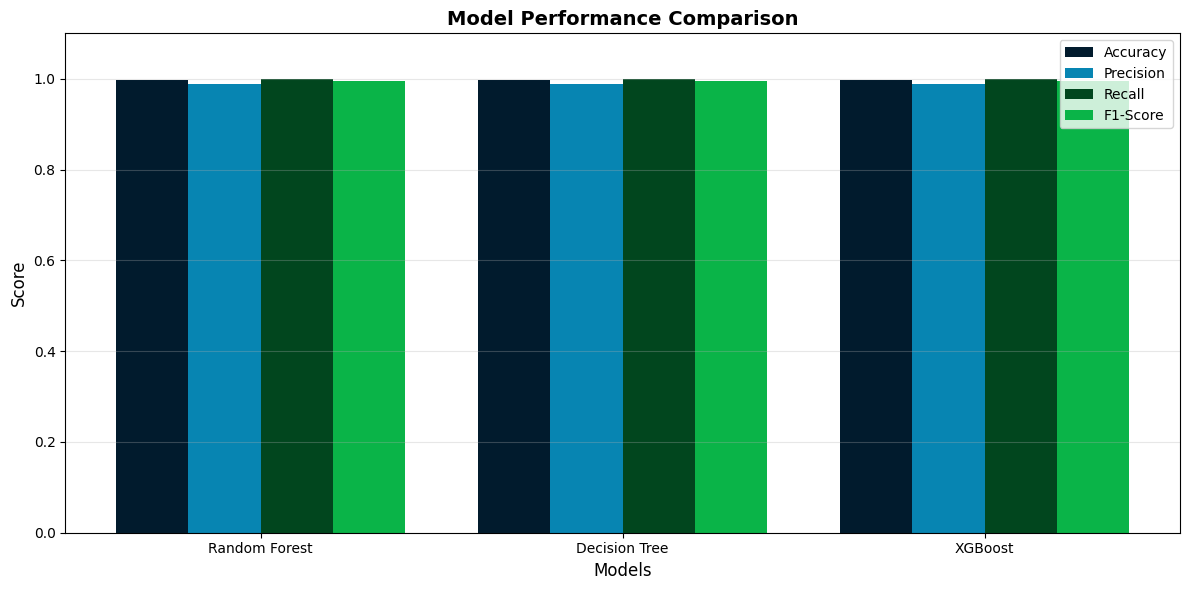


Using Random Forest for final predictions


'\nprint("CROSS-VALIDATION RESULTS")\n\nfor name, model in models.items():\n    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring=\'f1\')\n    print(f"\n{name}:")\n    print(f"  CV F1 Scores: {cv_scores}")\n    print(f"  Mean CV F1:   {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")\n    '

In [18]:
print("MODEL PERFORMANCE COMPARISON")

models = {
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'XGBoost': xgb_model
}

# Store results
results = []
best_model_name = None
best_f1 = 0

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall:    {rec:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name

print("\n" + "="*60)
print(f"BEST MODEL: {best_model_name} (F1-Score: {best_f1:.3f})")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ["#011b2d", "#0785B2", "#01461e", "#0ab448"]

for i, metric in enumerate(metrics):
    values = [r[metric] for r in results]
    ax.bar(x + i*width, values, width, label=metric, color=colors[i])

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([r['Model'] for r in results])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# Use best model for final predictions
final_model = models[best_model_name]
print(f"\nUsing {best_model_name} for final predictions")

"""
print("CROSS-VALIDATION RESULTS")

for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
    print(f"\n{name}:")
    print(f"  CV F1 Scores: {cv_scores}")
    print(f"  Mean CV F1:   {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    """

In [19]:
import pickle

# Save model and scaler to pickle file
with open('leetcode_model.pkl', 'wb') as f:
    pickle.dump({'model': final_model, 'scaler': scaler}, f)

print("Model saved!")

Model saved!


# Importance Score

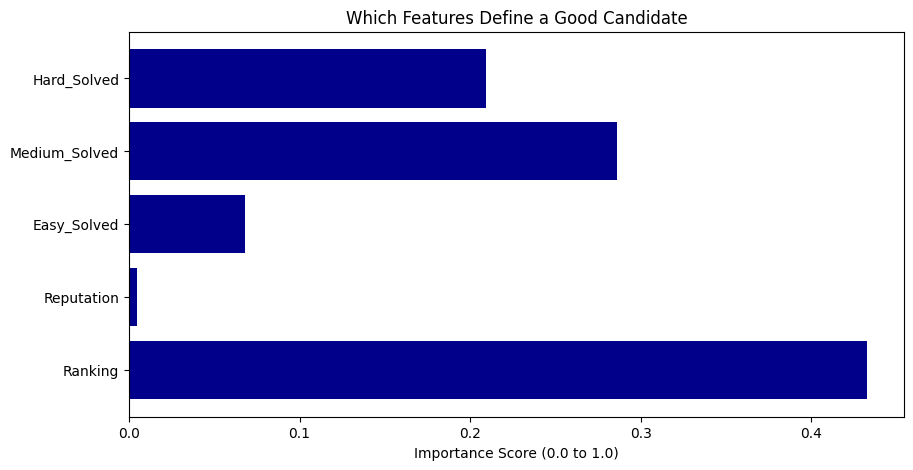

In [20]:
# Get importance scores
importances = rf_model.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(features, importances, color='darkblue')
plt.title('Which Features Define a Good Candidate')
plt.xlabel('Importance Score (0.0 to 1.0)')
plt.show()

# Export to CSV

In [21]:
# Recalculate predictions using the best model
df['Selection_Probability'] = final_model.predict_proba(X)[:, 1]

# Sort by probability and get top 10
top_10_candidates = df.sort_values(by=['Selection_Probability'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates[['Username','Ranking','Reputation','Easy_Solved', 'Medium_Solved', 'Hard_Solved', 'Selection_Probability']])
top_10_candidates[['Username','Ranking','Reputation','Easy_Solved', 'Medium_Solved', 'Hard_Solved', 'Selection_Probability']].to_csv('../Shortlisted_candidates/leetcode_shortlisted_candidates.csv', index=False)


 TOP 10 CANDIDATE PICKS
         Username  Ranking  Reputation  Easy_Solved  Medium_Solved  \
1         sethles       77         533          872           1894   
2975        seryp     8815          16          317            766   
2973   ashish1729      528         644          738           1466   
5       dancooper     2519           1          533            996   
2971       glump1      349          25          698           1511   
902        seeean     7732          22          385            751   
905   vaibhav2740    31448          67          170            639   
908        y2587w      870           4          623           1235   
912   chuchuching    20870           4          251            583   
925       wssx349    16259          31          352            566   

      Hard_Solved  Selection_Probability  
1             732                    1.0  
2975          279                    1.0  
2973          452                    1.0  
5             315               